In [12]:
#alpha3版本内容：增加传输矩阵随机起伏 通过total函数控制训练时间控制 通过total函数控制内容存储文件夹 通过total函数控制结果预测数量

In [13]:
# 先说恢复误删单元格的操作
# 场景：不小心把某个cell给cut了，或者删除了单元格（前提不要关闭notebook窗口）。

# 解决方法： 先按Esc键进入命令模式，在按z键就会恢复。记住不要按Ctrl+z（这个只限没删除单元格的常规操作）

# 命令模式和编辑模式识别：
# 命令模式：左侧为蓝色。

In [14]:
#我们现在应该在master上弃用torch.nn.functional.tanh，因为现在已经合并了张量和变量。
#If you deprecate nn.functional.tanh I could do
# output = nn.Tanh()(input)

In [15]:
import h5py  #导入工具包
import numpy as np
import os
import torch
import torch.nn as nn
from torch import autograd
import torch.nn.functional as F
import time
import math
import h5py  #导入工具包
import os
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

from torch.nn.parameter import Parameter
from torch.nn import init
import zipfile
import torch.optim as optim

In [16]:
class Scattering_system_simulation:#python class ,#input shape
    def __init__(self,Win,Wout,device,sparseValue,I_random_range,proportionSigma):

        self.Matrix_R = self.sparseMatrixGenerate(Win,Wout,device,sparseValue)
        self.Matrix_I = self.sparseMatrixGenerate(Win,Wout,device,sparseValue)

        self.Win=Win
        self.Wout=Wout
        self.device=device
        self.I_random_range = I_random_range
        
        self.sigmaBasicProportion = 0.5/(Win*Win)
        self.proportionSigma = proportionSigma
    
    def sparseMatrixGenerate(self,Win,Wout,device,sparseValue):
        _sparseValue=torch.tensor([sparseValue],dtype=torch.float32)
        Matrix = torch.rand(Win*Win, Wout*Wout)
        #矩阵稀疏设置 rand是0-1均匀分布
        _sparseMatrix = torch.rand(Win*Win, Wout*Wout)
        _sparseMatrix = torch.where(_sparseMatrix>_sparseValue,torch.tensor([1.0]),torch.tensor([0.0]))
        Matrix = _sparseMatrix*Matrix
        
        _div = (Matrix).sum(dim=0,keepdim=True)+1e-6 #加一个小数防止为零时爆炸
        Matrix = Matrix/_div
        Matrix = Matrix.to(device)
        return Matrix
        
    def I_rand_Generation_everyRand(self):
        return torch.randn(1,self.Win*self.Win,device=self.device)*(self.I_random_range)+1
#     def I_rand_Generation_Fixed():
#     def I_rand_Generation_inputCorrelation():
    def generate(self, input):#input.shape = (Win,Win)
        with torch.no_grad():
            input_R=input.view(1,self.Win*self.Win)
            input_I=self.I_rand_Generation_everyRand()
            tempMatrix_R = self.Matrix_R
            tempMatrix_I = self.Matrix_I
            R1 = torch.matmul(input_R,tempMatrix_R)
            I1 = torch.matmul(input_I,tempMatrix_R)
            I2 = torch.matmul(input_R,tempMatrix_I)
            R2 = torch.matmul(input_I,tempMatrix_I)
            
           # return torch.nn.functional.sigmoid(torch.sqrt(torch.pow((R1-R2),2)+torch.pow((I1+I2),2)).view(self.Wout,self.Wout))
            return torch.sqrt(torch.pow((R1-R2),2)+torch.pow((I1+I2),2)).view(self.Wout,self.Wout)
        
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
def show_original_and_speckle(index,samples,labels):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(samples[index][0].cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(labels[index][0].cpu(),cmap='gray')
    plt.show()
def show_test_original_and_speckle(index,testSamples,testLabels):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(testSamples[index][0].cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(testLabels[index][0].cpu(),cmap='gray')
    plt.show()
    
#创建Dataset子类
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset
class subDataset(Dataset.Dataset):    
    #初始化，定义数据内容和标签
    def __init__(self, Data, Label,W,device):
        self.Data = Data
        self.Label = Label
        self.device = device
    #返回数据集大小
    def __len__(self):
        return len(self.Data)
    #得到数据内容和标签
    def __getitem__(self, index):
        data = self.Data[index].to(self.device)
        label = self.Label[index].to(self.device)
        return data, label

#网络构建 ：单一全连接 单一通道  存在前conv 无后conv
class Transmission_Matrix(nn.Module):
    def __init__(self,Win,Wout):  #batchsize * channelnum * W * W,  
        super(Transmission_Matrix, self).__init__()
        self.Matrix = nn.Linear(Win*Win, Wout*Wout, bias=True)
        self.Win = Win
        self.Wout = Wout
    def forward(self, input):
        W = input.shape[2]
        input = input.view(input.shape[0],input.shape[1],self.Win*self.Win)
        out = self.Matrix(input)
        out = out.view(input.shape[0],input.shape[1],self.Wout,self.Wout)
        return out
    
class EnhancedNet(nn.Module):
    def __init__(self,Win,Wout,Temp_feature_nums):
        super(EnhancedNet, self).__init__()
        self.head=nn.Sequential(
            nn.Conv2d(1,Temp_feature_nums,3,padding=3//2),
            nn.Tanh(),
            nn.Conv2d(Temp_feature_nums,Temp_feature_nums,3, padding=3//2),
            nn.Tanh(),
            nn.Conv2d(Temp_feature_nums,1,3, padding=3//2),
            nn.Tanh()
        )
        self.Matrix_r = Transmission_Matrix(Win,Wout)
        self.tailAct=nn.Sigmoid()
        
    def forward(self,input):
        result = self.tailAct(self.Matrix_r(self.head(input)))
        return result 
    
#showTestResult_XY = PositionXYGenerator(120,device)
def showTestResult(net,testSamples,testLabels,index,device):
    
    net.train(False)
    _sample = testSamples[index].to(device)
    with torch.no_grad():
        output = net(_sample.view(1,1,64,64))
    
    plt.figure()
    plt.subplot(131)
    plt.title("speckle")
    plt.imshow(testSamples[index][0].cpu(),cmap='gray')
    # plt.show()#show不需要写啦！！

    plt.subplot(132)
    plt.title("output")
    img = output[0][0].cpu().numpy()
    np.where(img > 0, img, 0)
    plt.imshow(output[0][0].cpu(),cmap='gray')

    plt.subplot(133)
    plt.title("real label")
    img_t = testLabels[index][0].cpu().numpy()
    np.where(img_t > 0, img_t, 0)
    plt.imshow(testLabels[index][0].cpu(),cmap='gray')
    plt.show()
    net.train(True)
    
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
    
def SaveResult(net,testSamples,testLabels,index,device,root_path,windows_or_linux='\\'):   
    
    net.train(False)
    _sample = testSamples[index].to(device)
    
    with torch.no_grad():
        output = net(_sample.view(1,1,64,64))

    mpimg.imsave(root_path+windows_or_linux+str(index)+'_speckle'+'.png',testSamples[index][0].cpu().numpy(),cmap='gray')
    mpimg.imsave(root_path+windows_or_linux+str(index)+'_reconstruction'+'.png',output[0][0].cpu().numpy(),cmap='gray')
    mpimg.imsave(root_path+windows_or_linux+str(index)+'_realLabel'+'.png',testLabels[index][0].cpu().numpy(),cmap='gray')
    net.train(True)
    
# PSNR.py
import numpy as np
import math
 
def psnr(target, ref):
    # target:目标图像  ref:参考图像  scale:尺寸大小
    # assume RGB image
    target_data = np.array(target)

    ref_data = np.array(ref)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt( np.mean(diff ** 2.) )
    scale=1.0
    return 20*math.log10(scale/rmse)

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
    
def set_psnr(net,testSamples,testLabels,index,device):   
    
    net.train(False)
    _sample = testSamples[index].to(device)
    
    with torch.no_grad():
        output = net(_sample.view(1,1,64,64))
    
    output = psnr(output[0][0].cpu().numpy(),testLabels[index][0].cpu().numpy())
    net.train(True)
    return output

import torch
import torch.nn.functional as F
from math import exp
import numpy as np
from torch.autograd import Variable


# 计算一维的高斯分布向量
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

# 创建高斯核，通过两个一维高斯分布向量进行矩阵乘法得到
# 可以设定channel参数拓展为3通道
def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window
 
# 计算SSIM
# 直接使用SSIM的公式，但是在计算均值时，不是直接求像素平均值，而是采用归一化的高斯核卷积来代替。
# 在计算方差和协方差时用到了公式Var(X)=E[X^2]-E[X]^2, cov(X,Y)=E[XY]-E[X]E[Y].
# 正如前面提到的，上面求期望的操作采用高斯核卷积代替。
def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=1):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1
 
        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range
 
    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)
 
    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)
 
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2
 
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
 
    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity
 
    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)
 
    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)
 
    if full:
        return ret, cs
    return ret
 
# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range
 
        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)
 
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
 
        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel
 
        return ssim(img1 ,img2 ,window_size=self.window_size ,window=self.window ,size_average=self.size_average ,val_range=self.val_range)
def ssim_calculate(ssim_class,image1,image2):
    with torch.no_grad():
        result=ssim_class(image1,image2)
    return result

#通过一个网络和散斑重建，并和Label计算SSIM
def netAndOriginalAndLabel_to_ssim(ssim_class,net,W1,W2,testSamples,testLabels,index,device):   
    net.train(False)
    _sample = (testSamples[index].view(1,1,W1,W1)).to(device)
    
    with torch.no_grad():
        output = net(_sample)

    output = ssim_calculate(ssim_class,output.cpu(),(testLabels[index].view(1,1,W2,W2))).numpy()
    net.train(True)
    return output

import zipfile
def zip_ya(startdir):
    file_news = startdir +'.zip' # 压缩后文件夹的名字
    z = zipfile.ZipFile(file_news,'w',zipfile.ZIP_DEFLATED) #参数一：文件夹名
    for dirpath, dirnames, filenames in os.walk(startdir):
        fpath = dirpath.replace(startdir,'') #这一句很重要，不replace的话，就从根目录开始复制
        fpath = fpath and fpath + os.sep or ''#这句话理解我也点郁闷，实现当前文件夹以及包含的所有文件的压缩
        for filename in filenames:
            z.write(os.path.join(dirpath, filename),fpath+filename)
    print ('压缩成功')
    z.close()

# if__name__=="__main__"
#     startdir = ".\\123"  #要压缩的文件夹路径
#     file_news = startdir +'.zip' # 压缩后文件夹的名字 
#     zip_ya(startdir，file_news)

In [23]:
def OneTrainingTotalFunction(ScatteringSystem,resultSavedPath,trainTime,reconstructedAndSavedTestNum):
    print("data preprocessing start...") 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    SSS = ScatteringSystem

    path = r'/root/code/images'
    dirs = os.listdir(path)
    trans_num = 10000

    original_image = []
    scatted=[]
    _t_trans_num=0
    for dir in dirs:
        if _t_trans_num<trans_num:
            _t_trans_num=_t_trans_num+1
            file = Image.open(path+'//'+dir)
            i=(np.array(file.convert('L'))/255).astype(np.float32)
            i=torch.from_numpy(i)
            original_image.append(i)
            _t=SSS.generate(i.to(device))
            scatted.append(_t.to('cpu'))
            file.close()

    np_original_data = np.zeros((trans_num,64,64), dtype = np.float32)
    np_scatted_data = np.zeros((trans_num,64,64), dtype = np.float32)
    for i in range(0,trans_num):
        np_original_data[i] = original_image[i]
        np_scatted_data[i] =scatted[i]

    samples=torch.from_numpy(np_original_data[0:9500]).view(9500,1,64,64)
    labels=torch.from_numpy(np_scatted_data[0:9500]).view(9500,1,64,64)

    testSamples = torch.from_numpy(np_original_data[9500:10000]).view(500,1,64,64)
    testLabels = torch.from_numpy(np_scatted_data[9500:10000]).view(500,1,64,64)

    #交换样本和标签
    temp=samples
    samples=labels
    labels=temp

    temp=testSamples
    testSamples=testLabels
    testLabels=temp

    print(samples.shape)
    print(labels.shape)
    print(testSamples.shape)
    print(testLabels.shape)
    print(samples.dtype)
    print(labels.dtype)
    print(testSamples.dtype)
    print(testLabels.dtype)
    print("Samples and labels OK") 

    index=10
    print("show_test_original_and_speckle: ",index) 
    show_test_original_and_speckle(index=index,testSamples=testSamples,testLabels=testLabels)
    
    print("dataset processing...") 
    dataset = subDataset(samples,labels,64,device)
    device_count = 1
    if(torch.cuda.device_count()>1):
        device_count = torch.cuda.device_count()
    batchSize = 16*device_count

    print("batchSize:",batchSize)
    dataloader = DataLoader.DataLoader(dataset,batch_size= batchSize, shuffle = True)
    print(dataset.__getitem__(10)[0].shape,dataset.__getitem__(10)[1].shape)
    
    print("network building...") 
    net = EnhancedNet(Win=64,Wout=64,Temp_feature_nums=64)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        net = nn.DataParallel(net)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    index = 8
    print("Untrained network reconstruction on test data: ",index)
    showTestResult(net,testSamples,testLabels,index,device)

    print("optimizer processing...") 
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=3e-4)
    
    print("planned time is :",trainTime," ,start train...")
    startTime = time.time()
    net.train(True)
    for epoch in range(200):  # loop over the dataset multiple times
        running_loss = 0.0
        if (time.time()-startTime)<trainTime:
            for i, data in enumerate(dataloader, 0):
                # get the inputs
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = torch.dist(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                #testReconstruction
                running_loss += loss.item()
        #         if i %100 ==99:    # print every 2000 mini-batches
        #             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
        #             running_loss = 0.0
                showTempNetResultNum = 3000
                if i %showTempNetResultNum == showTempNetResultNum-1:    # print every 2000 mini-batches
                    ticks = time.time()-startTime
                    print("当前时间戳为:", ticks)
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / showTempNetResultNum))
                    running_loss = 0.0
                    index = 10
                    showTestResult(net,testSamples,testLabels,index,device)
    net.train(False)
    print('totalTrainTime : ',(time.time()-startTime))
    print('Finished Training')
    
    ssim_class=SSIM(val_range=1)
    print("creat ssim caculate class")

    #将测试集的散斑图片、原图像和重建图像 以及将对应的名称的PSNR和SSIM保存到list中。
    print("计算500测试集中每张PSNR SSIM 并将相关输出保存......")
    SimulationSystemResult_PSNR_SSIM=[]
    average_psnr=0
    average_ssim=0
    
    root_path = resultSavedPath
    if not os.path.exists(root_path):
        os.makedirs(root_path) 
    root_path_for_imageResult = resultSavedPath+"//"+"imageResult"
    if not os.path.exists(root_path_for_imageResult):
        os.makedirs(root_path_for_imageResult) 
    root_path_for_qualityData = resultSavedPath+"//"+"qualityResult"
    if not os.path.exists(root_path_for_qualityData):
        os.makedirs(root_path_for_qualityData) 
    with open(root_path_for_qualityData+"//"+"qualityResult.txt", 'w' ) as f:
        imageResult_root_path=root_path_for_imageResult
        windows_or_linux='//'
        net.train(False)
        for index in range(500):
            _sample = testSamples[index].to(device)
            with torch.no_grad():
                output = net(_sample.view(1,1,64,64))
            if index < reconstructedAndSavedTestNum :
                mpimg.imsave(imageResult_root_path+windows_or_linux+str(index)+'_speckle'+'.png',testSamples[index][0].cpu().numpy(),cmap='gray')
                mpimg.imsave(imageResult_root_path+windows_or_linux+str(index)+'_reconstruction'+'.png',output[0][0].cpu().numpy(),cmap='gray')
                mpimg.imsave(imageResult_root_path+windows_or_linux+str(index)+'_realLabel'+'.png',testLabels[index][0].cpu().numpy(),cmap='gray')

            singe_psnr = psnr(output[0][0].cpu().numpy(),testLabels[index][0].cpu().numpy())
            average_psnr=average_psnr+singe_psnr

            singe_ssim = ssim_calculate(ssim_class,output.cpu(),testLabels[index].view(1,1,64,64)).numpy()
            average_ssim = average_ssim + singe_ssim

            s="result_"+str(index)+"psnr_and_ssim"
            SimulationSystemResult_PSNR_SSIM.append((s,singe_psnr,singe_ssim))
            f.writelines(s+' '+str(singe_psnr)+' '+str(singe_ssim)+'\n')
            print((s,singe_psnr,singe_ssim))
        average_psnr = average_psnr/500
        average_ssim = average_ssim/500

    with open(root_path_for_qualityData+"//"+"averageQualityResult.txt", 'w' ) as f:
        f.writelines('average_psnr : '+str(average_psnr)+'\n')
        f.writelines('average_ssim : '+str(average_ssim)+'\n')
        
    print("average PSNR and SSIM :  ",average_psnr,average_ssim)
    print("result save complete")

data preprocessing start...
torch.Size([9500, 1, 64, 64])
torch.Size([9500, 1, 64, 64])
torch.Size([500, 1, 64, 64])
torch.Size([500, 1, 64, 64])
torch.float32
torch.float32
torch.float32
torch.float32
Samples and labels OK
show_test_original_and_speckle:  10


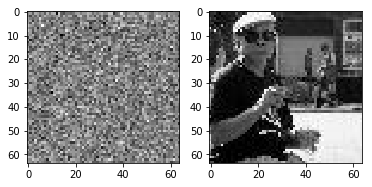

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


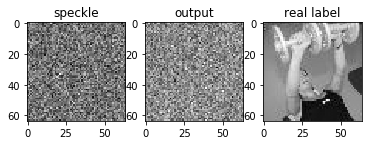

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  601.9584715366364
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 25.690201521992172, array(0.744937, dtype=float32))
('result_1psnr_and_ssim', 28.050110110066413, array(0.83441633, dtype=float32))
('result_2psnr_and_ssim', 25.56546562380452, array(0.7979357, dtype=float32))
('result_3psnr_and_ssim', 25.53142767099427, array(0.7485743, dtype=float32))
('result_4psnr_and_ssim', 24.400870874913217, array(0.8281456, dtype=float32))
('result_5psnr_and_ssim', 23.586757615256175, array(0.84483534, dtype=float32))
('result_6psnr_and_ssim', 20.479936741677506, array(0.8249824, dtype=float32))
('result_7psnr_and_ssim', 28.02136916362049, array(0.7636899, dtype=float32))
('result_8psnr_and_ssim', 25.576143643279615, array(0.7737003, dtype=float32))
('result_9psnr_and_ssim', 23.84756111934245, array(0.7314264, dtype=float32))
('result_10psnr_and_ssim', 21.8660

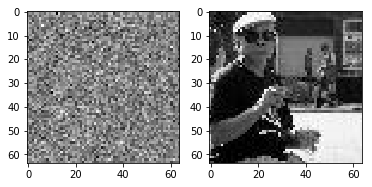

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


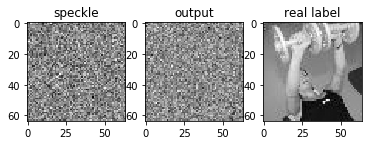

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  602.0939753055573
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 21.111183718293134, array(0.54830223, dtype=float32))
('result_1psnr_and_ssim', 20.55304209347463, array(0.45306656, dtype=float32))
('result_2psnr_and_ssim', 20.359199011799546, array(0.5091261, dtype=float32))
('result_3psnr_and_ssim', 21.321291501155727, array(0.5730735, dtype=float32))
('result_4psnr_and_ssim', 20.196205476936292, array(0.55260205, dtype=float32))
('result_5psnr_and_ssim', 19.18656864256992, array(0.6121427, dtype=float32))
('result_6psnr_and_ssim', 16.809700888619044, array(0.6229416, dtype=float32))
('result_7psnr_and_ssim', 21.962453269697622, array(0.46884748, dtype=float32))
('result_8psnr_and_ssim', 20.13631991424691, array(0.5229897, dtype=float32))
('result_9psnr_and_ssim', 18.998055299984305, array(0.40522367, dtype=float32))
('result_10psnr_and_ssim', 18

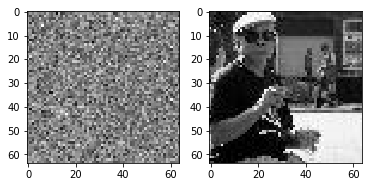

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


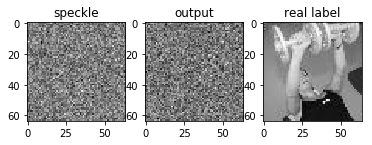

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  601.1656882762909
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 18.91324045806386, array(0.39044383, dtype=float32))
('result_1psnr_and_ssim', 18.06829524259749, array(0.26242253, dtype=float32))
('result_2psnr_and_ssim', 18.29600950957049, array(0.37296632, dtype=float32))
('result_3psnr_and_ssim', 18.33909572632584, array(0.43014783, dtype=float32))
('result_4psnr_and_ssim', 18.047148689643045, array(0.4227187, dtype=float32))
('result_5psnr_and_ssim', 16.969834481202863, array(0.41758722, dtype=float32))
('result_6psnr_and_ssim', 14.985923435764793, array(0.46199012, dtype=float32))
('result_7psnr_and_ssim', 20.164857337424632, array(0.33141497, dtype=float32))
('result_8psnr_and_ssim', 17.737902814604315, array(0.35675678, dtype=float32))
('result_9psnr_and_ssim', 16.61822192101387, array(0.24365795, dtype=float32))
('result_10psnr_and_ssim', 

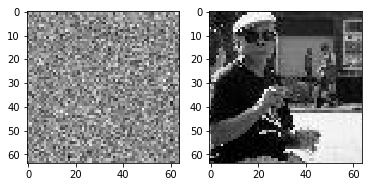

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


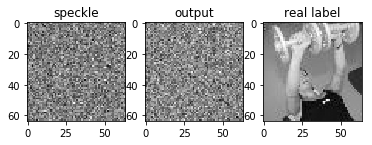

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  600.4133141040802
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 17.754433594516268, array(0.32924315, dtype=float32))
('result_1psnr_and_ssim', 17.28640174835632, array(0.21917674, dtype=float32))
('result_2psnr_and_ssim', 16.98910075982813, array(0.2659465, dtype=float32))
('result_3psnr_and_ssim', 17.50152139520615, array(0.38072655, dtype=float32))
('result_4psnr_and_ssim', 16.872044410618, array(0.3181984, dtype=float32))
('result_5psnr_and_ssim', 16.2052473476527, array(0.3619885, dtype=float32))
('result_6psnr_and_ssim', 14.181881332566824, array(0.36017293, dtype=float32))
('result_7psnr_and_ssim', 18.393146473392, array(0.2742394, dtype=float32))
('result_8psnr_and_ssim', 16.574293113731606, array(0.27136913, dtype=float32))
('result_9psnr_and_ssim', 16.20622691855976, array(0.17259426, dtype=float32))
('result_10psnr_and_ssim', 15.4111143

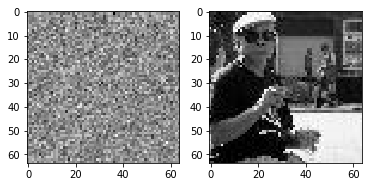

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


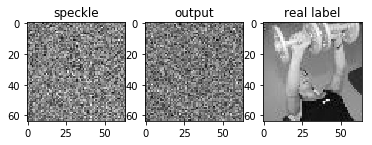

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  600.111932516098
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 16.418389152691837, array(0.2606606, dtype=float32))
('result_1psnr_and_ssim', 15.825704523859365, array(0.15754305, dtype=float32))
('result_2psnr_and_ssim', 16.043573795126985, array(0.22984594, dtype=float32))
('result_3psnr_and_ssim', 16.801152866279402, array(0.33542642, dtype=float32))
('result_4psnr_and_ssim', 16.26201660637395, array(0.28556898, dtype=float32))
('result_5psnr_and_ssim', 15.402121915181521, array(0.260794, dtype=float32))
('result_6psnr_and_ssim', 13.327946593543205, array(0.27577215, dtype=float32))
('result_7psnr_and_ssim', 18.035777551906946, array(0.23883718, dtype=float32))
('result_8psnr_and_ssim', 15.540775995545403, array(0.23983556, dtype=float32))
('result_9psnr_and_ssim', 15.049177397459381, array(0.11224394, dtype=float32))
('result_10psnr_and_ssim',

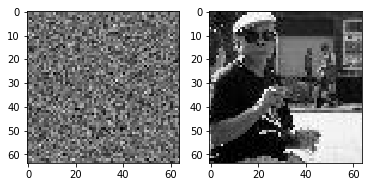

dataset processing...
batchSize: 16
torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
network building...
Untrained network reconstruction on test data:  8


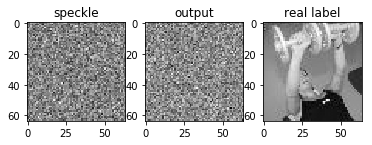

optimizer processing...
planned time is : 600  ,start train...
totalTrainTime :  603.8605163097382
Finished Training
creat ssim caculate class
计算500测试集中每张PSNR SSIM 并将相关输出保存......
('result_0psnr_and_ssim', 16.057963100075426, array(0.2618257, dtype=float32))
('result_1psnr_and_ssim', 16.460965855617786, array(0.16305669, dtype=float32))
('result_2psnr_and_ssim', 15.794869040322137, array(0.17291553, dtype=float32))
('result_3psnr_and_ssim', 16.12291465307929, array(0.30469966, dtype=float32))
('result_4psnr_and_ssim', 15.554595145256993, array(0.21836549, dtype=float32))
('result_5psnr_and_ssim', 15.07729185802366, array(0.24079601, dtype=float32))
('result_6psnr_and_ssim', 12.932176572629068, array(0.22493742, dtype=float32))
('result_7psnr_and_ssim', 16.8418200668066, array(0.21369265, dtype=float32))
('result_8psnr_and_ssim', 15.5692559567881, array(0.18943755, dtype=float32))
('result_9psnr_and_ssim', 14.828413541855145, array(0.09996852, dtype=float32))
('result_10psnr_and_ssim', 1

In [24]:
z = zipfile.ZipFile('images.zip', 'r')
z.extractall(path=r'/root/code/images')
z.close()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SSS=Scattering_system_simulation(64,64,device,sparseValue=0,I_random_range=0.00,proportionSigma=0)

DifferentSigmaList = [0,0.1,0.2,0.3,0.4,0.5]
resultRootSavedPath=r"root/code/TestIFlow"
for sigma in DifferentSigmaList:
    resultSavedPath = resultRootSavedPath +'//'+'sigma'+str(sigma)+'result'
    SSS.I_random_range = sigma
    OneTrainingTotalFunction(SSS,resultSavedPath=resultSavedPath,trainTime=600,reconstructedAndSavedTestNum=20)
zip_ya(resultRootSavedPath)
print("processing success")